# Assignment 5: Statistical Analysis (30 pt)

Use as many Python and markdown cells per question as you deem necessary. **DO NOT SUBMIT CODE THAT DOES NOT RUN.** You will lose points for code that throws errors. 

Questions 1 and 2 will use data describing various wetlands, intertidal zones, and ocean conditions in the United States from 1972-2015. This data has been adapted from [publicly available data from NASA](https://daac.ornl.gov/NACP/guides/Tidal_Wetland_Estuaries_Data.html). Note that this file uses the value `-9999` to denote missing data. This file's path is `data/tidal_wetland_estuaries.csv`.

Question 3 will be using time series data describing the proportion of electricity produced by coal in high income countries from [the World Bank](https://data.worldbank.org/indicator/EG.ELC.COAL.ZS). The path to the file is `data/coal-production.csv`.


## Question 1: t-tests (10 pt)

Using the data from `tidal_wetland_estuaries.csv`, test the hypothesis that soil organic carbon density (column name: `soc_density`) is **larger** in the East coast than the West coast with a t-test. Interpret the t-test. (5 pt)

Defend your choice of which type of t-test you used (3 pt).

Do the data meet the requirement for normal data? Why or why not? (2 pt) 

In [1]:
import scipy.stats as stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('white')

df = pd.read_csv('data/tidal_wetland_estuaries.csv')

df.head()

,name,coast,estu_latitude,estu_longintude,estu_dep,estu_perim,land_area,land_latitude,land_longitude,population,...,ocean_salinity_mean,air_temp_mean,frost_days_per_yr,ocean_sst_mean,ocean_diss_inorg_p,ocean_no3,tide_flow,mean_precip,mean_temp,soc_density
0,Florida Bay,GULF,25.039940,-80.731770,0.62000,614000.000,9.048954e+08,25.187310,-80.727540,3421,...,36.2,24.4,0.0,26.50,0.07,0.810,1.000000e+09,1251.831801,24.594719,0.087
1,South Ten Thousand Islands,GULF,25.311330,-81.057020,0.63000,597000.000,3.069216e+09,25.440250,-80.791070,235792,...,36.1,24.6,0.0,26.40,0.08,0.780,3.000000e+08,1355.907147,24.320596,0.000
2,North Ten Thousand Islands,GULF,25.724280,-81.377640,0.73000,906000.000,4.921106e+09,25.982520,-81.273680,9268,...,36.0,24.1,0.0,26.30,0.09,0.790,6.000000e+08,1416.239789,23.873671,0.084
3,Rookery Bay,GULF,25.998750,-81.756010,0.50000,148000.000,3.304589e+08,26.042920,-81.677710,14858,...,36.0,23.9,0.0,26.10,0.08,0.670,4.000000e+07,1432.519416,23.510000,0.086
4,Charlotte Harbor,GULF,26.754031,-82.103018,1.65938,507261.119,1.169284e+10,27.167615,-81.772154,597644,...,35.9,23.2,1.0,25.65,0.10,0.545,7.000000e+08,1320.275690,22.869199,0.073


In [2]:
df_east = df.loc[(df['coast']=='EAST') & (df['soc_density']!=-9999),:]
df_west = df.loc[(df['coast']=='WEST') & (df['soc_density']!=-9999),:]

# making t test
stats.ttest_ind(df_east['soc_density'], df_west['soc_density'], alternative="greater")

Ttest_indResult(statistic=8.45031778669312, pvalue=5.765284478012742e-13)

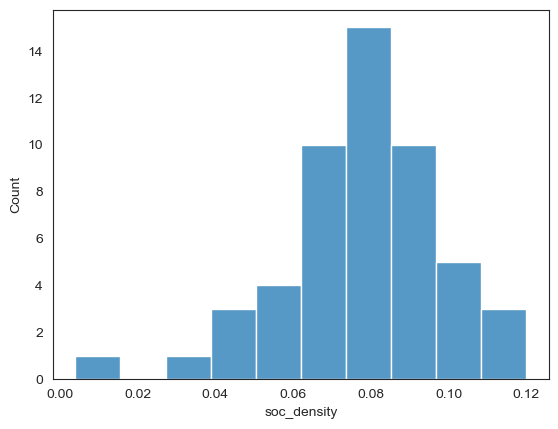

In [3]:
sns.histplot(df_east['soc_density'])
plt.savefig('eastCoastHistPlot.png')

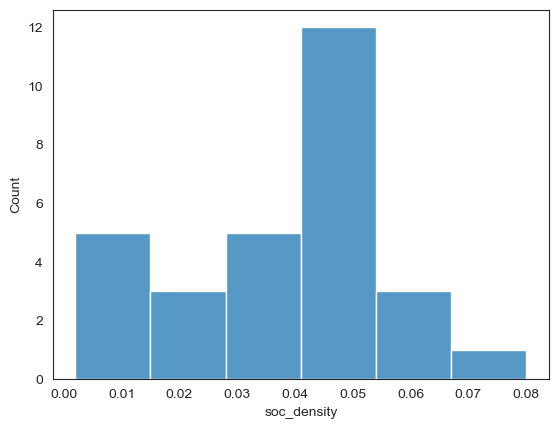

In [4]:
sns.histplot(df_west['soc_density'])
plt.savefig('westCoastHistPlot.png')

Because the p-value calculated is less than .05, we reject the null hypothesis in favor of the alternative hypothesis. The null hypothesis says that there is no significant difference between the soil organic carbon density on the east and west coast (or that the difference is less than 0, which would mean that the soil organic carbon density is greater on the West Coast than the East Coast), and the alternative hypothesis says that soil organic carbon density is greater on the East Coast than the West Coast. As a result, since we are rejecting the null hypothesis based on the p-value, this t-test supports the idea that the soil organic carbon density is greater in the East Coast than the West Coast. Because the t-value (statistic) is relatively high at 8.45, we can say that the difference between sample means of the two groups is high (relative to their group variances). Thus, our test is more reliable and that we can reject the null hypothesis with more confidence, since it is a t value that is not close to 0. 

I used a one-tailed, 2 sample t-test because we have two samples (East Coast and West Coast) that we are comparing to see if we can say that the mean of one is greater than the other with confidence. Because the hypothesis includes a directional relationship, it is a one-tailed test. It would not make sense to use a 1 sample t-test because there are two samples, and using a two-tailed test would not be comparing if one is greater than the other, but instead if there is a difference between them at all.

The assumptions for a 2 sample t-test are:
- Continuous data -> not discrete categories (same as 1-sample)
- The data are a representative random sample (same as 1-sample)
- Data are approximately normally distributed (same as 1-sample)
- The two groups have similar variances

It meets the continuous data assumption because the soil organic carbon density column has continuous data, rather than discrete values (see the df.head printout above for confirmation of this). The data are a representative random sample because the data describes all types of wetlands and zones across a long period of time. I would say that the data are not exactly normally distributed, based on my analysis of the histplots above. The East Coast histplot has a decent tail, while the West Coast histplot just doesn't seem to follow the normal bell curve shape as much as usual. The two groups definitely don't have the same variance based on the plots above (see the x-axis values rather than just the way it is spread out, as they are different on the two plots). However, they would likely be considered to have similar variances, although this may be a matter of opinion (I would say based on the range of data values, I would consider them to have similar variance). Based on looking at all of the assumptions for a 2-sample t-test, I would say that the data don't quite meet the requirements for normal data and to be used for a 2 sample t-test, although they meet most of the requirements.

## Question 2

Using the data from `tidal_wetland_estuaries.csv`, create a linear model to predict mean ocean salinity (column name: `ocean_salinity_mean`) from other environmental factors. (2 pt)

Create a model with a high R-squared value (> 0.80). All coefficients should be significant, and none should have VIF values above 5.0. (4 pt)

Interpret the summary of the model, focusing on the R-squared value and the regression coefficients. (3 pt)

Make diagnostic plots to ensure your data meets the assumptions of linear regression. The necessary functions have been imported for you. (1 pt).

,estu_latitude,estu_longintude,estu_dep,estu_perim,land_area,land_latitude,land_longitude,population,tide_ht,estu_salinity,ocean_salinity_mean,air_temp_mean,frost_days_per_yr,ocean_sst_mean,ocean_diss_inorg_p,ocean_no3,tide_flow,mean_precip,mean_temp,soc_density
estu_latitude,1.000000,-0.135823,0.238712,-0.120852,-0.094265,0.985909,-0.120586,-0.090038,0.667042,0.150752,-0.852660,-0.972151,0.858896,-0.946930,0.913406,0.727220,0.238581,0.315233,-0.970350,0.089215
estu_longintude,-0.135823,1.000000,-0.073094,0.171240,-0.021408,-0.122464,0.998703,0.012705,0.151456,0.126402,0.305917,0.020597,0.336521,0.094058,-0.363031,0.280087,0.167175,-0.219979,-0.014577,0.559394
estu_dep,0.238712,-0.073094,1.000000,0.016693,-0.006384,0.233491,-0.069422,0.027441,0.337379,0.270034,-0.203900,-0.270574,0.210644,-0.286125,0.250011,0.215188,0.373722,-0.225367,-0.250159,-0.071816
estu_perim,-0.120852,0.171240,0.016693,1.000000,0.218305,-0.077480,0.164415,0.333008,-0.193631,-0.185451,0.007988,0.140862,-0.073233,0.108683,-0.142615,-0.085430,0.593699,-0.031468,0.131058,0.112161
land_area,-0.094265,-0.021408,-0.006384,0.218305,1.000000,0.049037,-0.046255,0.957338,-0.127078,-0.212179,-0.057248,0.113508,-0.106084,0.102892,-0.051614,-0.004501,0.008872,0.073536,0.104899,-0.038693
land_latitude,0.985909,-0.122464,0.233491,-0.077480,0.049037,1.000000,-0.111918,0.053226,0.651763,0.101677,-0.862551,-0.956711,0.850753,-0.929149,0.902181,0.731924,0.258222,0.330132,-0.959954,0.094585
land_longitude,-0.120586,0.998703,-0.069422,0.164415,-0.046255,-0.111918,1.000000,-0.013397,0.160625,0.130964,0.296514,0.005719,0.350254,0.078883,-0.350234,0.293208,0.171790,-0.213408,-0.029260,0.562066
population,-0.090038,0.012705,0.027441,0.333008,0.957338,0.053226,-0.013397,1.000000,-0.132681,-0.185926,-0.046231,0.099664,-0.090633,0.077660,-0.059859,-0.026863,0.135655,0.002974,0.095502,-0.007012
tide_ht,0.667042,0.151456,0.337379,-0.193631,-0.127078,0.651763,0.160625,-0.132681,1.000000,0.341248,-0.454109,-0.691815,0.698411,-0.633574,0.548389,0.648145,0.233592,0.062591,-0.713396,0.207793
estu_salinity,0.150752,0.126402,0.270034,-0.185451,-0.212179,0.101677,0.130964,-0.185926,0.341248,1.000000,-0.021489,-0.222201,0.237810,-0.265133,0.092095,0.200921,0.123176,-0.359857,-0.191734,-0.113747


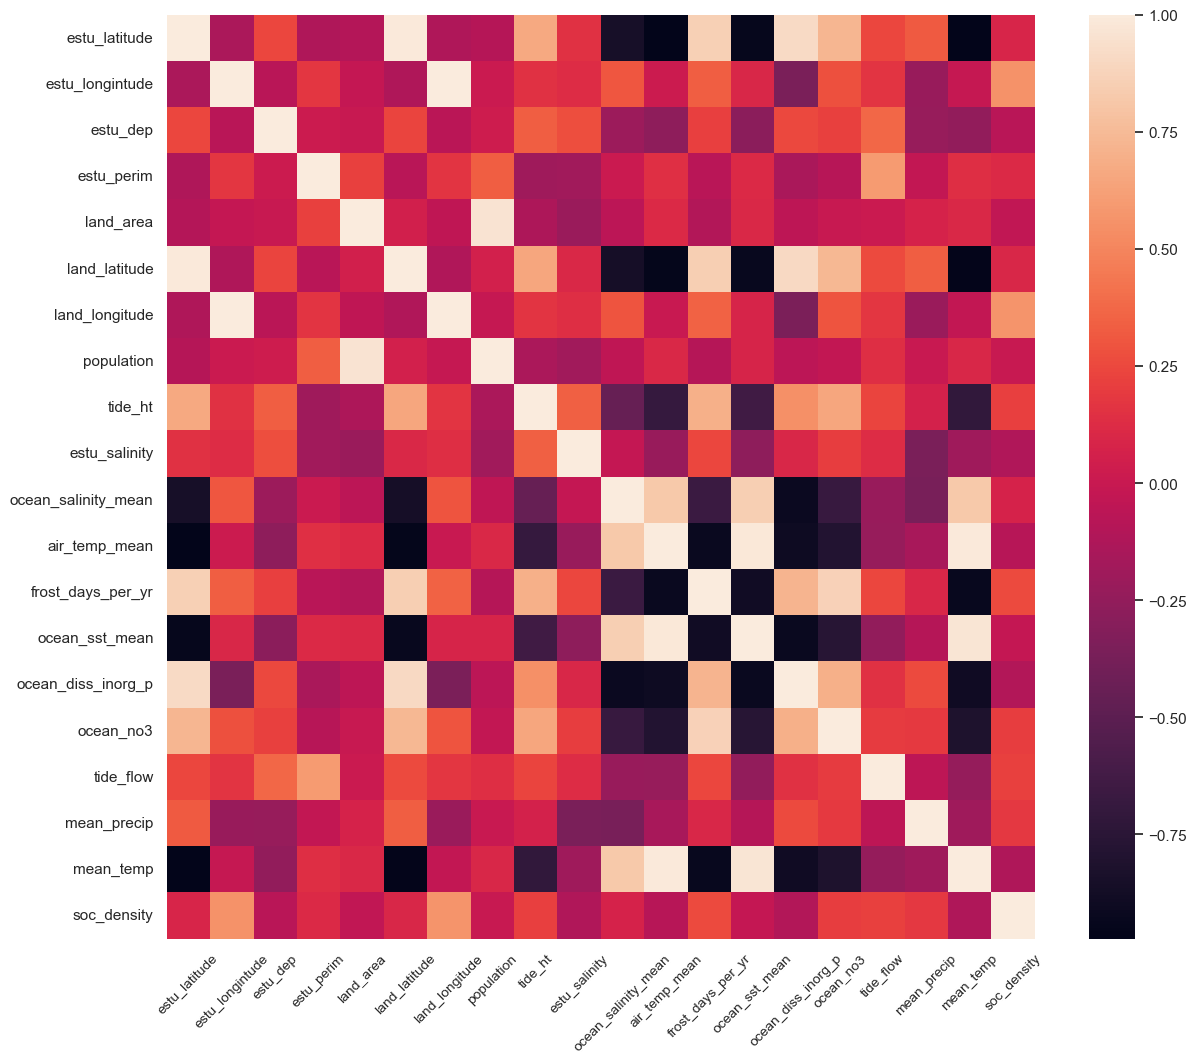

In [28]:
from utils import Linear_Reg_Diagnostic # do not change!
# using the same df as in question 1

df_salinity = df.loc[(df['ocean_salinity_mean']!=-9999),:]

# using correlations to decide which environmental factors to use to predict
# mean ocean salinity

correlations = df_salinity.corr()

sns.set(rc={'figure.figsize': (14,12)})
sns.heatmap(correlations)
plt.xticks(rotation=45, fontsize=10)
plt.savefig('OceanSalinityMeanCorrelations.png')
# for some reason, using .corr() again results in a much nicer output table
# compared to printing correlations
df_salinity.corr()


To decide which environmental factors to use to predict the mean ocean salinity, I am looking at the correlations and choosing the variables with the strongest correlation with mean ocean salinity, whether it is positive or negative. Based on the table and heatmap, I found that the top variables that correlate the most with mean ocean salinity, from highest correlation down, include ocean_diss_inorg_p (-0.914380), land_latitude (-0.862551), estu_latitude (-0.852660), and ocean_sst_mean (0.849060). Consequently, these are the variables that I chose to create my linear model. In the end, it took me so long to find variables that gave both a high R-squared value and low VIF factors, but I just did trial and error until I finally found some.

The coefficients are statistically significant, since the P>|t| (shown in the summary) are < .05. Also, the VIF values are below 5, as shown in the printed table down below.

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     Q("ocean_salinity_mean")   R-squared:                       0.855
Model:                                  OLS   Adj. R-squared:                  0.853
Method:                       Least Squares   F-statistic:                     327.7
Date:                      Fri, 28 Apr 2023   Prob (F-statistic):           2.66e-47
Time:                              16:56:57   Log-Likelihood:                -107.21
No. Observations:                       114   AIC:                             220.4
Df Residuals:                           111   BIC:                             228.6
Df Model:                                 2                                         
Covariance Type:                  nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             37.0098      0.197    187.469      0.000      36.619      37.401
ocean_diss_inorg_p    -8.1350      0.346    -23.504      0.000      -8.821      -7.449
mean_precip           -0.0005      0.000     -3.825      0.000      -0.001      -0.000
==============================================================================
Omnibus:                        1.402   Durbin-Watson:                   0.296
Prob(Omnibus):                  0.496   Jarque-Bera (JB):                0.958
Skew:                           0.196   Prob(JB):                        0.619
Kurtosis:                       3.218   Cond. No.                     8.56e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.56e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

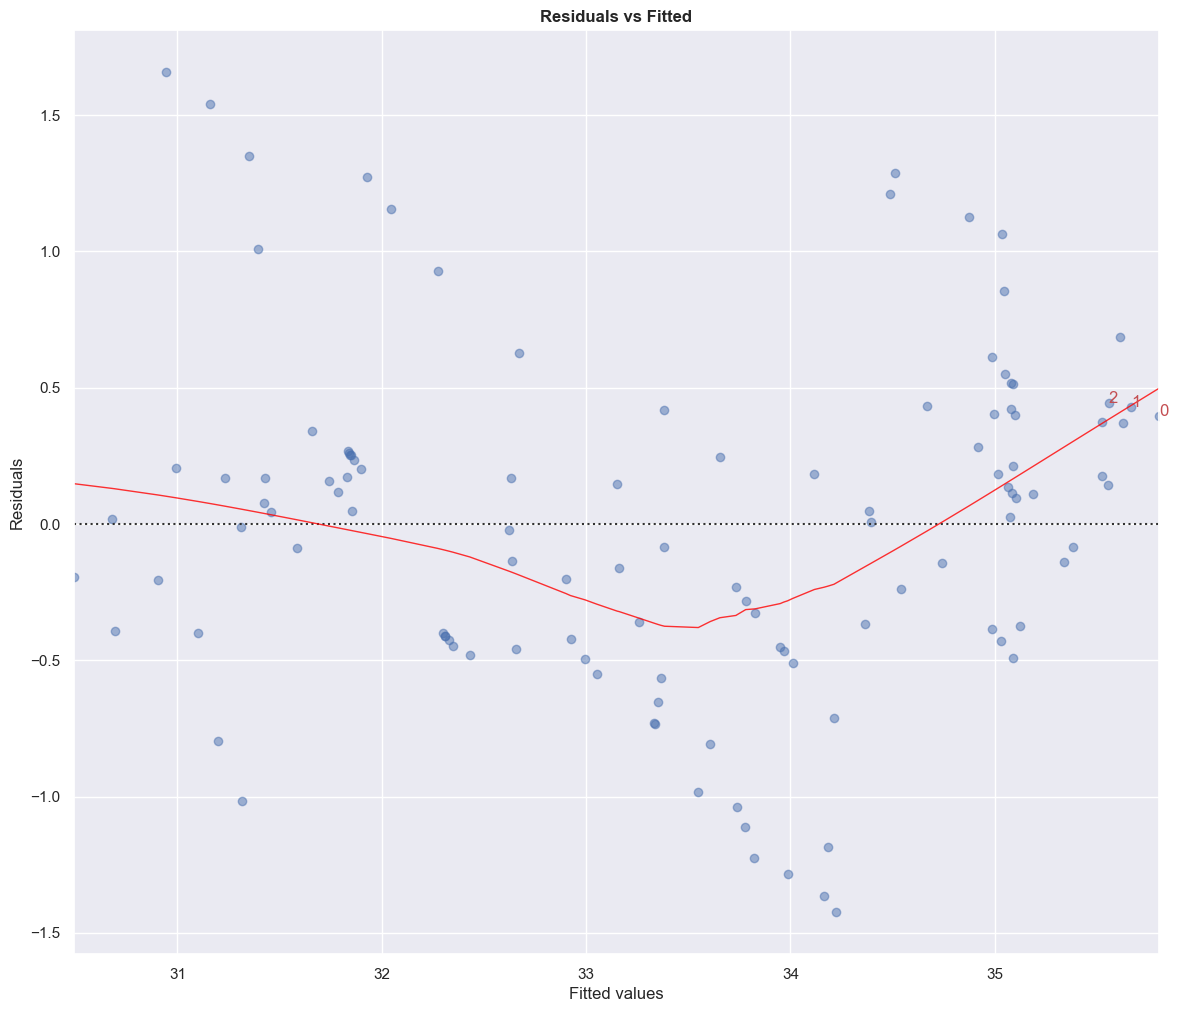

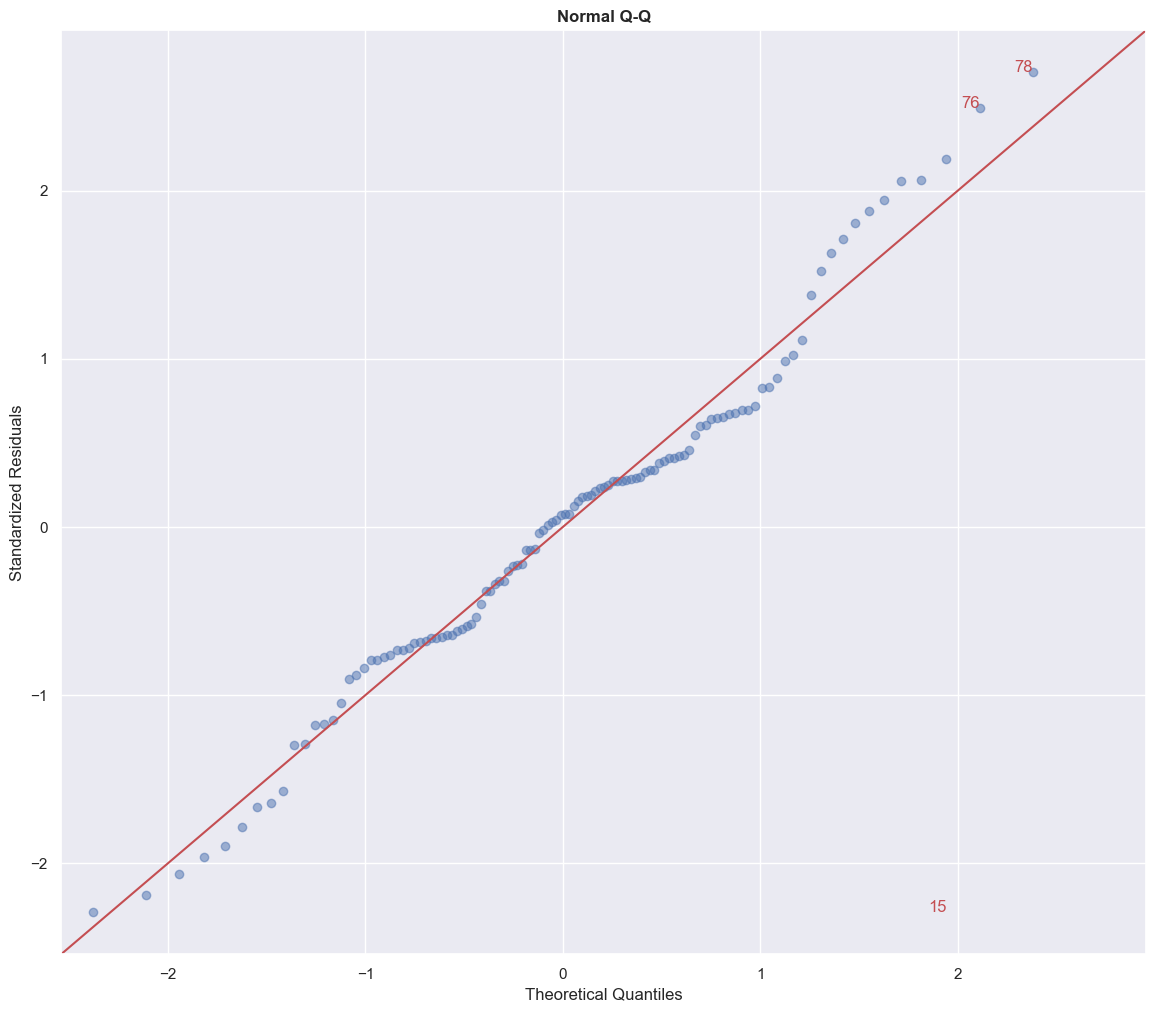

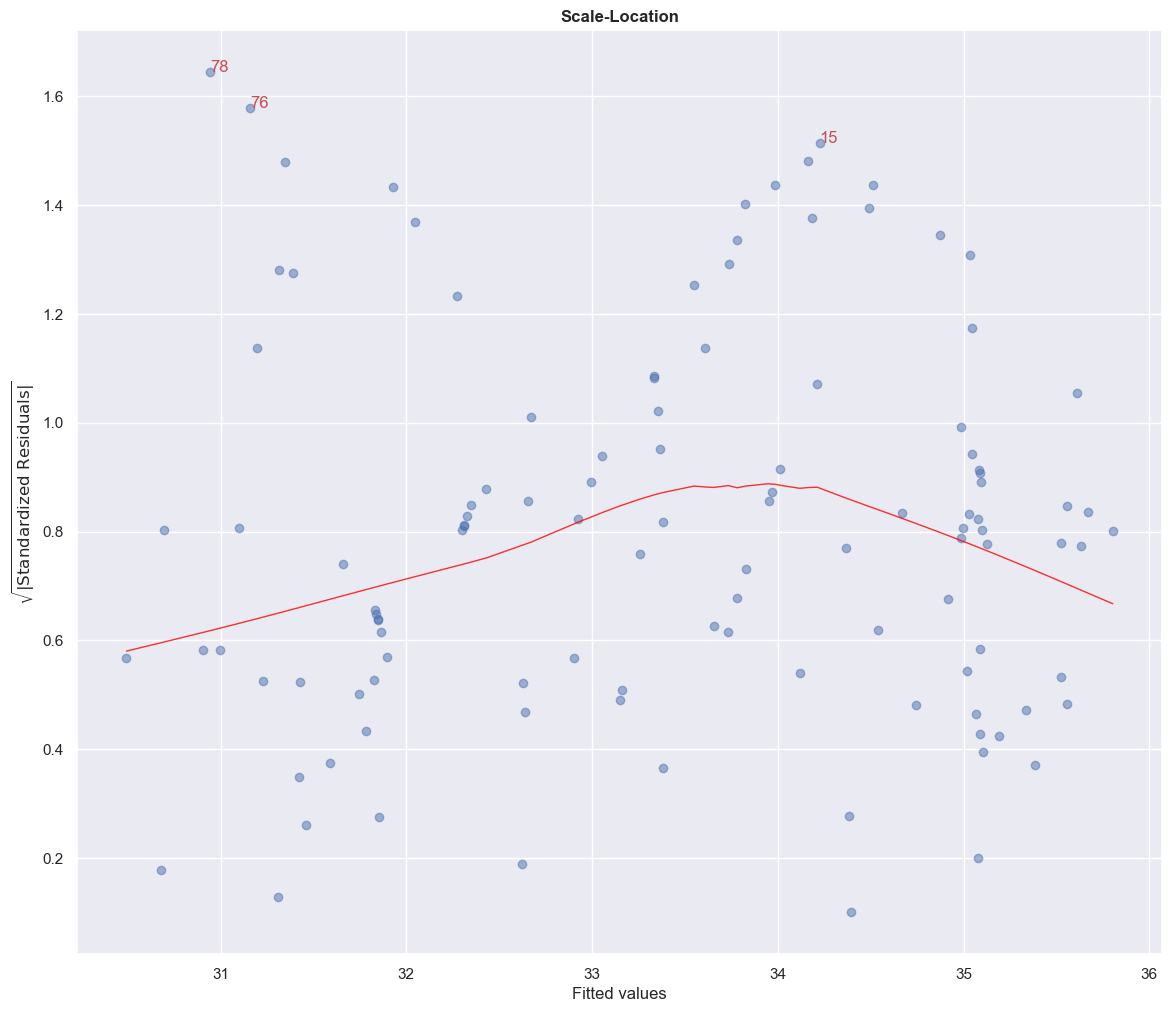

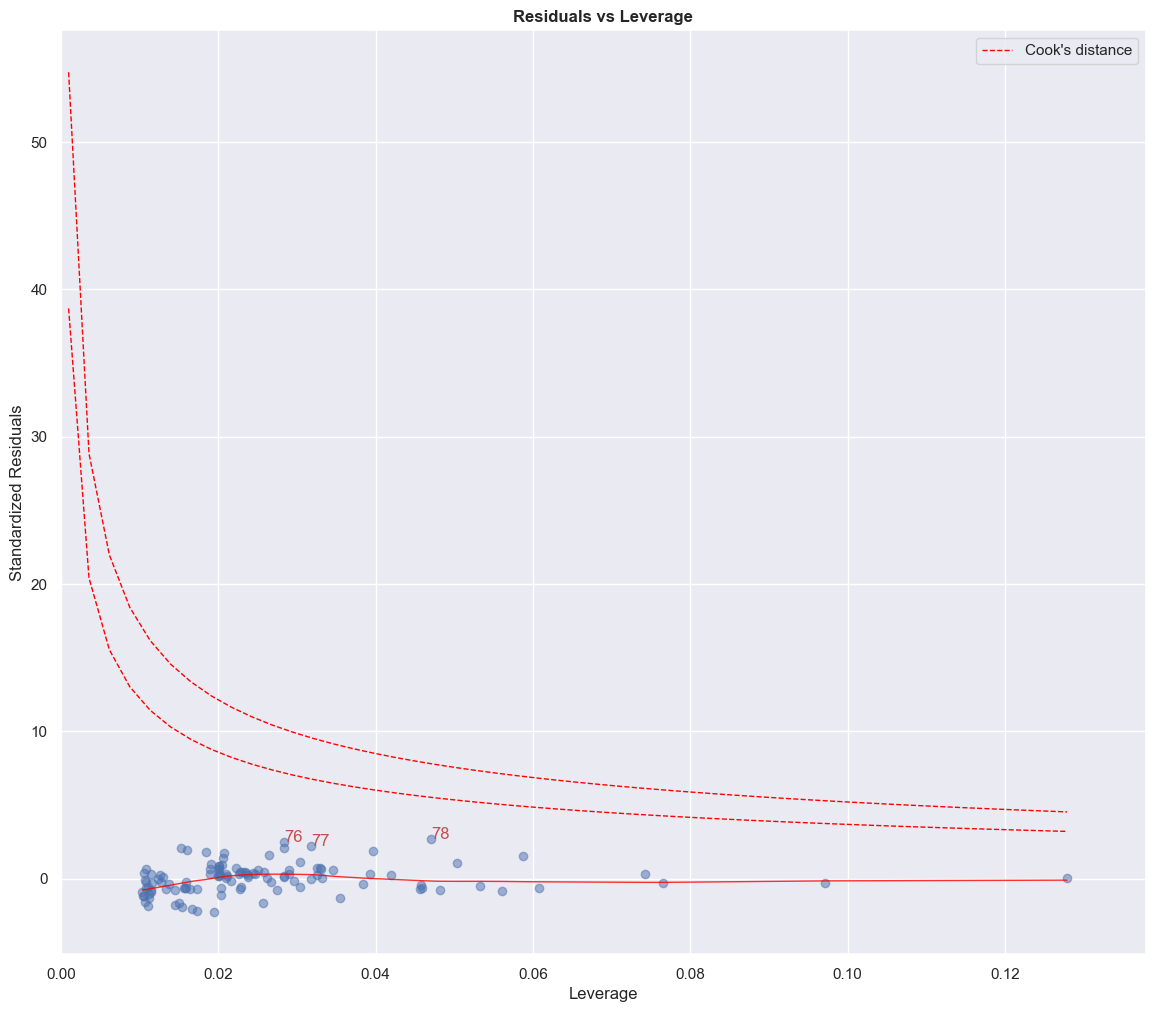

In [64]:
import statsmodels.formula.api as smf
df_sal_vars = df_salinity.loc[(df_salinity['mean_precip']!=-9999) &
                              (df_salinity['ocean_diss_inorg_p']!=-9999), :]

strong_corr_model = smf.ols(formula='Q("ocean_salinity_mean") ~ ocean_diss_inorg_p + mean_precip',
                      data=df_sal_vars).fit()

diagnostics = Linear_Reg_Diagnostic(strong_corr_model)
diagnostics.residual_plot()
plt.savefig('wetlandResidualPlot.png')
diagnostics.qq_plot();
plt.savefig('wetlandQQPlot.png')
diagnostics.scale_location_plot();
plt.savefig('wetlandScaleLocationPlot.png')
diagnostics.leverage_plot();
plt.savefig('wetlandLeveragePlot.png')
strong_corr_model.summary()

The summary of the data has an Adjusted R-squared value of .853, which means that the model is a strong fit with the variables, using the environmental factors that I put in to model the ocean_salinity_mean variable. The regression coefficients of the two variables are both negative, which means that there is a negative correlation between each variable and the variable that they are getting compared to, which is the mean ocean salinity. However, the absolute value of the regression coefficient for ocean_diss_inorg_p is much higher than that of precip_mean, so there is a stronger negative correlation between that variable with the mean ocean salinity compared to precip_mean. 

The diagnostic plots are all shown above, and mostly seem to exhibit that the data meets the assumptions for linear regression.

In [65]:
diagnostics.vif_table()
# checking VIF Factor

             Features  VIF Factor
1  ocean_diss_inorg_p        1.07
2         mean_precip        1.07
0           Intercept       11.26


## Question 3 

Using the `coal-production.csv` data, model the proportion of electricity produced with coal in high income countries over time with an ARIMA model. 

Process the data to be useable for time series analysis. (2 pt)

Display your data. Does it appear to have a trend? If so, describe the trend. (1 pt)

Test for stationarity. (1 pt)

Make an ARIMA model of the time series, either by manually testing different types, or with an auto-ARIMA. What type of ARIMA model was found to be the best fit? (2 pt)

Visualize the fitted values of the ARIMA model, being sure to label each line. (2 pt)

Make a forecast for 25 years after the conclusion of the time series and visualize with observed and fitted values. (2 pt)

In [9]:
df_coal = pd.read_csv('data/coal-production.csv')

df_coal.head()

,year,electricity_prod
0,1960,45.904345
1,1961,45.730794
2,1962,46.411172
3,1963,46.599523
4,1964,46.102588


In [10]:
# processing data
df_coal['year'] = pd.to_datetime(df_coal['year'], format='%Y')
df_coal = df_coal.set_index('year').sort_index() # makes sure years are in order
df_coal.head()

,electricity_prod
year,
1960-01-01,45.904345
1961-01-01,45.730794
1962-01-01,46.411172
1963-01-01,46.599523
1964-01-01,46.102588


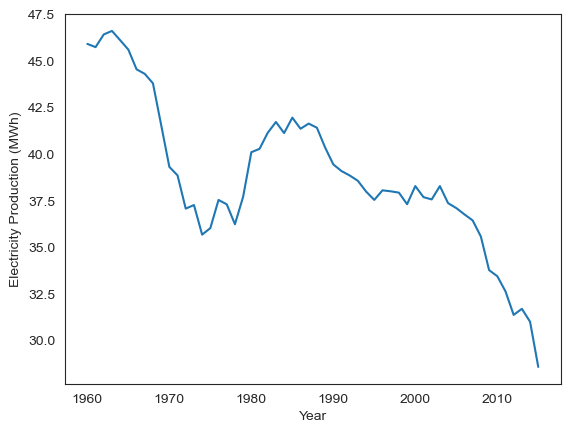

In [18]:
# displaying data
fig, ax = plt.subplots()
ax.plot(df_coal['electricity_prod']);
ax.set_xlabel('Year')
ax.set_ylabel('Electricity Production (MWh)')
plt.savefig('CoalProductionDataDisplay.png')

Yes, it looks like there is a trend of decreasing electricity produced using coal over time between
1960 and 2-15, although it isn't completely linear and undeviating from the median.

In [12]:
# testing for stationarity
from statsmodels.tsa.stattools import adfuller

def adf_print(time_series):
    adf_output = adfuller(time_series)
    stat = adf_output[0]
    pval = adf_output[1]
    print('ADF Statistic:', stat)
    print('p-value:', pval)
    return None

adf_print(df_coal)

ADF Statistic: 1.872154432675823
p-value: 0.9984818799941668


The p-value here, which represents the probability of observing this time series if the true process is not stationary, is very large, so we have to accept the null hypothesis that our time series is not stationary.

In [13]:
# using auto-arima to make a model of the time series
from pmdarima import auto_arima

auto_arima_model = auto_arima(df_coal['electricity_prod'])
auto_arima_model.summary()

/Users/Sydney/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/Sydney/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/Users/Sydney/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/Sydney/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/Users/Sydney/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(se

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   56
Model:               SARIMAX(1, 1, 1)   Log Likelihood                 -71.684
Date:                Thu, 27 Apr 2023   AIC                            149.368
Time:                        10:14:05   BIC                            155.390
Sample:                             0   HQIC                           151.697
                                 - 56                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8478      0.140      6.074      0.000       0.574       1.121
ma.L1         -0.6020      0.230     -2.622      0.009      -1.052      -0.152
sigma2         0.7894      0.171      4.604      0.000       0.453       1.125
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):                 1.33
Prob(Q):                              0.68   Prob(JB):                         0.51
Heteroskedasticity (H):               0.72   Skew:                             0.36
Prob(H) (two-sided):                  0.49   Kurtosis:                         3.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The type of ARIMA model that was found to be the best fit is SARIMAX(1,1,1), so the best fit AR, I, and MA values are all 1.

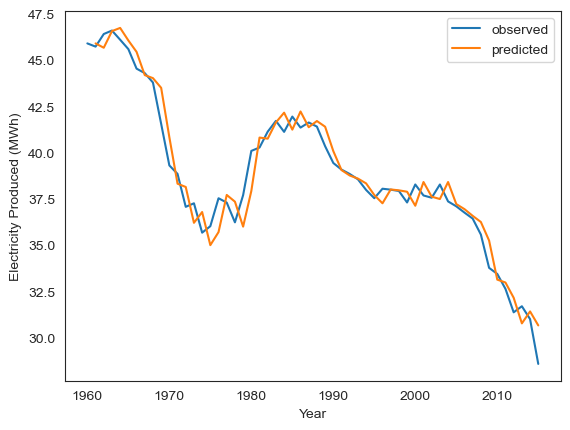

In [17]:
# visualizing the fitted values of the ARIMA model

in_samp_pred = auto_arima_model.predict_in_sample()
in_samp_pred = pd.Series(in_samp_pred, index=df_coal.index)

fig, ax = plt.subplots()
ax.plot(df_coal, label='observed')
ax.plot(in_samp_pred[1:], label='predicted')
ax.set_xlabel('Year')
ax.set_ylabel('Electricity Produced (MWh)')
ax.legend();
plt.savefig('ARIMAFittedValues.png')

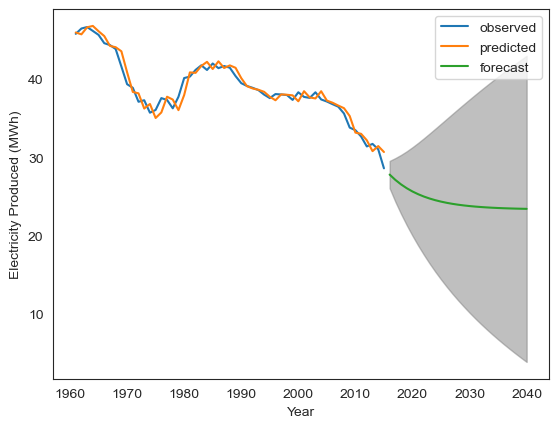

In [16]:
# making a forecast for 25 years after the conclusion of the time series
forecast, ci = auto_arima_model.predict(25, return_conf_int=True)
future_dates = pd.date_range(df_coal.index[-1], periods=26, freq='AS-JAN',inclusive='neither')

fig, ax = plt.subplots()
ax.plot(df_coal[1:], label='observed')
ax.plot(in_samp_pred[1:], label='predicted')
ax.plot(future_dates,forecast, label='forecast')
ax.fill_between(future_dates, ci[:,0], ci[:,1], color = 'gray', alpha=0.5) # our confidence intervals
ax.set_xlabel('Year')
ax.set_ylabel('Electricity Produced (MWh)')
ax.legend();
plt.savefig('coalProductionForecast.png')